# **ETPoF** Homework 3
Annemarie Linnenbank & Tommie Verouden

*22 March 2024*

In [1]:
# Ensure the module is automatically reloaded when rerunning the import command.
%load_ext autoreload
%autoreload 2

In [2]:
import etpof
import matplotlib.pyplot as plt
import cv2 as cv

## Particle Tracking (25 points)
### 1) **Calibration** (3 pts)

We start by illustrating the calibration of camera a). Below it, we outline 
the steps taken to obtain these results. The functions used can be found in `functions1.py`, which is part of the `etpof` module, added as an appendix below.

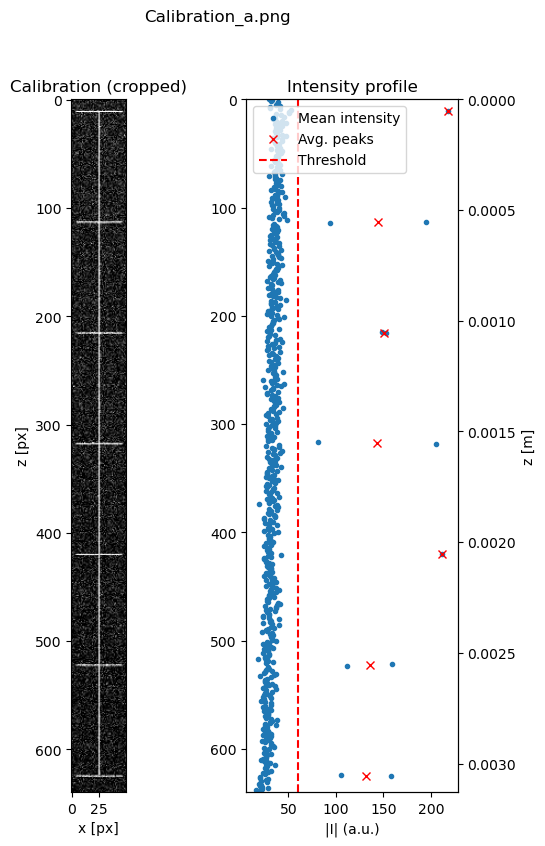

In [3]:
directory = 'PTV'
roi_calib = [200, 250, 30, 670]
calib_dist = 0.5 # [m]
threshold = 60

_, _, _, = etpof.calibrate_cameras(directory, roi_calib, calib_dist, threshold,
                                   peak_method='weighted_avg',
                                   file_prefix='Calibration_', 
                                   plot=[True, False], verbose=False,
                                   precision=7, units='m')


For each camera, we go through the following calibration steps:
1. We import the (grayscale) calibration image and manually inspect it to determine a suitable region of interest (ROI), containing the calibration pattern, but not the scale numbers and as little background noise as possible.
2. We assume that the background noise is the same throughout the image, and 
that the horizontal lines are, in fact, horizontal. _On closer inspection, the vertical line connecting the calibration lines has no angle: it follows a single pixel column._
3. These two assumptions allow us to average the pixel values in the ROI in the horizontal direction to obtain a 1D "intensity profile" of the calibration image.
4. We then calculate the subpixel position of the peaks in the intensity 
profile by taking the average $z$ coordinate of all values around each peak that are larger than a set threshold. In the plot, these are the points to the right of the red dashed line. In calculating the average, we weigh each row by its intensity value. _Note that we could have also used fitted a Gaussian or 
another function to determine the exact peak, but this method already 
resulted in such a small error, and it did not seem to make much sense to fit a function to the 1 or 2 data points making up each peak._
5. Like in the previous homework assignment, we calculate all possible 
distances between the peaks (i.e., from the top line to the second one, one 
to three, one to four, etc.) and get a resolution value corresponding to each line-line combination by dividing between the distance in "real space". This distance is given by the calibration distance divided by the number of lines separating the two peaks.
6. Finally, we average the resolution values, weighted by the distance in 
real space, to obtain the final resolution value. This way, the longer distances, which contain a smaller error, weigh more heavily. The (weighted) standard deviation of the set of resolution values then gives us a measure of the error in the calibration.

Besides the resolution value, we also obtain an offset value, given by the average difference in position of the seven lines between the images of camera b) and a). This offset will later be used to align the images of the cameras.

In [4]:
res_avg, res_std, offset\
    = etpof.calibrate_cameras(directory, roi_calib, calib_dist, threshold)

print(f'\nResolution difference across the image: '
      f'{(abs(res_std[1] - res_std[0]) * 860 * 1000):.2f} mm.')

==> Calibration_a.png:
The average resolution is 0.0048892 m/px,
with a standard deviation of 0.0000018 m/px (0.038 %).
==> Calibration_b.png:
The average resolution is 0.0048895 m/px,
with a standard deviation of 0.0000017 m/px (0.034 %).
The offfset is -0.0000494 m.

Resolution difference across the image: 0.13 mm.


The results of the calibration are shown above, and are very similar for the 
two cameras at $4.89$ $\rm{mm/px}$. The standard error is also very similar, at $2$ $\rm{\mu m/px}$. The difference in resolution between the two cameras can only account for a total error of about $0.13$ $\rm{mm}$ across the entire height of the images of about 0.13 mm.
 
In the next parts, we will use the resolution values corresponding to the camera with which the image was taken, and apply the offset (about to the coordinates in camera b). 

### 2) **Particle detection** (3 pts)

For detecting the particles, we have written the following algorithm. To be 
subpixel-accurate, we have tried to perform the least possible number of destructive operations. The functions used can be found in `functions2.py`, which is also part of the `etpof` module in the appendix. The steps below are performed on each image separately.

#### 1. Pre-processing
- We start by reading the image file and pre-processing the image. The goal 
here is to remove the (noisy) background while keeping the greyscale values of the particles intact.
- We apply a bilateral filter to the image to remove noise while keeping the 
edges sharp. This filter works by replacing the intensity of each pixel with a (Gaussian) weighted average of the intensities of nearby pixels. However, for each nearby pixel, the difference in (color) intensity is also taken into account using another (Gaussian) kernel. Therefore, we supply the filter with two kernel sizes. These values are determined empirically, and we have found that the filter works well with a larger colour kernel size than the spatial kernel size.
- A second bilateral filter with smaller kernel sizes is applied to remove finer details in the image.
- Remaining dim pixels and rough edges around the particles are removed by applying a threshold operation that sets pixels below a certain intensity to zero.
- We further clean up the background by using a hit-or-miss filter to remove horizontal or vertical stripes that do not have any (diagonal) neighbours. This works well to prevent false positives later on.

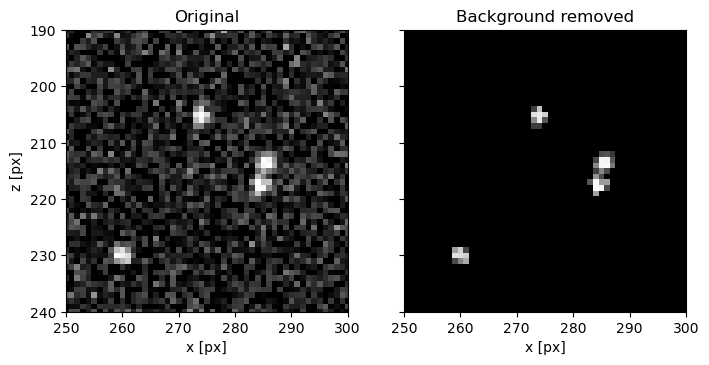

In [5]:
# Remove background from an example image
test_image = etpof.read_image('PTV/a1.png')
processed_image = etpof.remove_background(test_image)

# Plot a part of the original and processed image
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(test_image, cmap='gray')
ax[0].set_xlim([250, 300])
ax[0].set_ylim([240, 190])
ax[0].set_xlabel('x [px]')
ax[0].set_ylabel('z [px]')
ax[0].set_title('Original')
ax[1].imshow(processed_image, cmap='gray')
ax[1].set_xlim([250, 300])
ax[1].set_ylim([240, 190])
ax[1].set_xlabel('x [px]')
ax[1].set_yticklabels([])
ax[1].set_title('Background removed')
plt.show()


As can be seen, we are left with just the particles, and their details are 
still intact (albeit slightly dimmer). From this processed image, we extract 
the contours of the particles, and filter out contours with a too small area.

#### 2. Finding the particle centres
For each contour, we will be following the steps below to find the particle 
centre contained within it with subpixel accuracy. For this we use two 
versions of the image: one "background-less", where every pixel that is not  
part of this contour is set to zero, and one "isolated", where the contour 
and surrounding background pixels are kept, but all other contours are made 
black.
- We find the rectangular bounding box of the contour (with a margin) and 
find any local maxima in the "background-less" image within this box. Maxima 
with an intensity below a certain threshold are discarded, since stray pixels
 at the edges of the particles turned out to be a problem. If this gives no 
 results, the contour will be discarded; it must have been a false
 positive. Note that the maxima resulting from this calculation are 
 often clustered in groups of multiple pixels with the same high intensity.
 - There are many cases in which two particles together are seen as one 
 single contour. Therefore, we continue by splitting groups of maxima into 
 clusters. We do this by generating a matrix with the distance between all 
 maxima. By checking which entries in each column are below a given distance 
 threshold, we can determine which pixels are actually "connected". We then 
 remove any combinations that are simply a subset of a larger cluster (after 
 all, maximum #2 might be close to maximum #1 and maximum #3, but that does 
 not mean that #1 will show up as a neighbour of #3). This leaves us with 
 clustered groups of maxima.
  - Next, we consider each cluster separately. When a cluster consists of 
  multiple pixels, we reduce that to a single (integer pixel) coordinate by 
  applying a small Gaussian blur - this time to the "isolated" image, as to 
  also take the edges (that might have been marked as part of the background) 
  into account. The local maxima of the blurred image are found, rejecting 
  any that are not close to the original cluster. This process of "destroying 
  neighbours" is repeated until one maximum comes out of the algorithm. However,
   an exception is made for the rare occasions when the blur accidentally 
   causes there to be no maximum anymore, in which case the first maximum of 
   the original cluster is simply taken (this part of the algorithm could be 
   improved upon). To prevent this while loop from running indefinitely, we 
   also set a maximum number of iterations.

#### 3. Subpixel accuracy
Now that we have identified a single pixel that serves as the local 
 maximum of each cluster within the contour, it is time to move towards 
 subpixel accuracy. The main part of this calculation is to fit two Gaussian 
 functions to the "isolated" box, centred on (and with the height of) the local 
 maximum - in the $x$ (or $y$) and $z$ direction, respectively. The size of 
 cluster before destroying the neighbours is used as initial guess for the standard 
deviation of the Gaussian. However, for a contour with a double peak, this 
causes a problem: the other peak might interfere. In order to determine 
which pixels to use for this fitting operation, we calculate the bisector at
the midpoint between the maximum of the current cluster and the maxima of 
the other cluster(s). The pixels on the "opposite" side of the bisector are
blacked out, and the Gaussians are fitted to the remaining pixels. Any failed fits are rejected (which might be the cause of any false negatives).
Note that all parts of the algorithm are robust for clusters containing three
 or more maxima too.

The coordinates are saved, and the standard errors in the fit are provided as uncertainty of the coordinates, although at the moment, we did not get to utilise these values. Finally, the process is repeated for the next cluster, contour and image. An example of a complicated case is shown below.

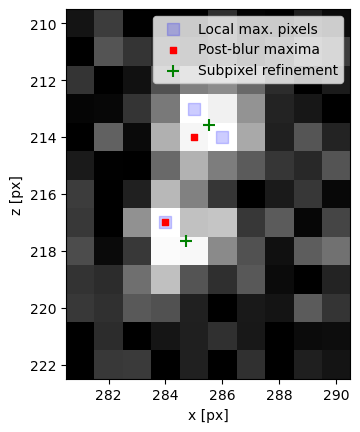

In [38]:
# Find the contours in the example
contours, _ = cv.findContours(processed_image, cv.RETR_EXTERNAL,
                              cv.CHAIN_APPROX_SIMPLE)

_ = etpof.find_particle_center(test_image, contours, 15, plot_all=True)

The results for camera a and b are shown below.

In [43]:
# For camera a
coordsA, intensitiesA, coords_errA, intensities_errA, particles_foundA \
    = etpof.analyze_camera('PTV', 'a', res_avg[0], offset[0],
                           min_contour_area=1, min_intensity=200, 
                           neighbor_dist=2.5,
                           box_margin=3, max_iter=5, verbose=True, 
                           plot_particles=False)

Processing images: 100%|██████████| 200/200 [00:12<00:00, 16.36it/s]

Found between 63 and 66 particles in each image, with a median of 65.0.


In [44]:
# For camera b
coordsB, intensitiesB, coords_errB, intensities_errB, particles_foundB \
    = etpof.analyze_camera('PTV', 'b', res_avg[1], offset[1],
                           min_contour_area=1, min_intensity=200, 
                           neighbor_dist=2.5,
                           box_margin=3, max_iter=5, verbose=True, 
                           plot_particles=False)

Processing images: 100%|██████████| 200/200 [00:12<00:00, 16.10it/s]

Found between 63 and 67 particles in each image, with a median of 66.0.


The number of particles found in each frame slightly differs between the two 
cameras.

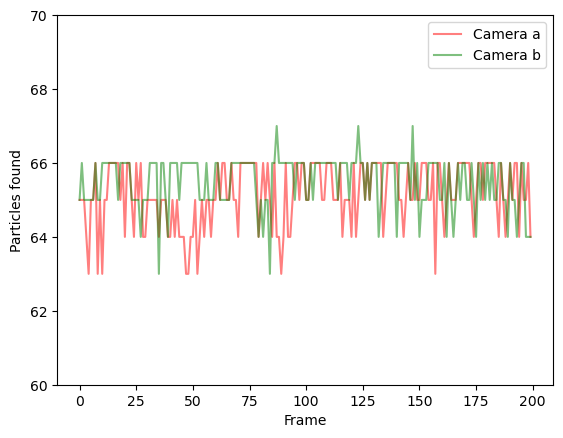

In [57]:
# Plot the number of particles found by camera a and b over time in one figure
fig, ax = plt.subplots()
ax.plot(range(200), particles_foundA, alpha=0.5, c="r",
label='Camera a')
ax.plot(range(200), particles_foundB, alpha=0.5, c="g", 
            label='Camera b')
ax.set_xlabel('Frame')
ax.set_ylabel('Particles found')
ax.set_ylim([60, 70])
ax.legend()
plt.show()

Converting the pixel values to meters and plotting all particle coordinates at 
once, gives us a good impression of the 
trajectories.

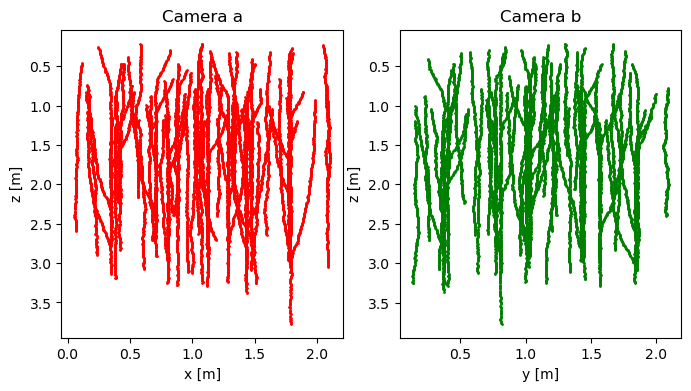

In [61]:
# Plot the particle coordinates of all frames in one image
fig, ax = plt.subplots(1,2, figsize=(8, 4))
ax[0].scatter(coordsA[:, 1], coordsA[:, 0], c='r', s=1)
ax[0].set_xlabel('x [m]')
ax[0].set_ylabel('z [m]')
ax[0].invert_yaxis()
ax[0].set_title('Camera a')
ax[1].scatter(coordsB[:, 1], coordsB[:, 0], c='g', s=1)
ax[1].set_xlabel('y [m]')
ax[1].set_ylabel('z [m]')
ax[1].invert_yaxis()
ax[1].set_title('Camera b')
plt.show()

## Appendix

Todo: add the etpof module here!